In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

In [2]:
# Load preprocessed dataset
df = pd.read_csv("Processed_Bosch_Dataset.csv")

In [3]:
# Select relevant features
features = ["Days_Since_Last_Calibration", "Days_Until_Next_Calibration", "Calibration_Interval_Years"]
target = "Days_Until_Next_Calibration"  # Predict when the next calibration is due

In [8]:
# Load the scaler from 'scaler.pkl'
scaler = joblib.load("scaler.pkl")

In [13]:
# Apply the same transformation to maintain consistency
features = ["Calibration_Interval_Years", "Months_Remaining", "Days_Since_Last_Calibration", "Days_Until_Next_Calibration"]
df[features] = scaler.transform(df[features])  # Use transform() instead of fit_transform()

In [14]:
# Convert data to supervised learning format
def create_sequences(data, target_col, seq_length=5):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length][target_col])
    return np.array(X), np.array(y)

In [15]:
# Convert to LSTM input format
X, y = create_sequences(df[features], target)

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [17]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)  # Predict next calibration date
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Compile Model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [19]:
# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0867 - mae: 0.2906 - val_loss: 0.0182 - val_mae: 0.1348
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0101 - mae: 0.0857 - val_loss: 0.0094 - val_mae: 0.0967
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0095 - mae: 0.0872 - val_loss: 1.3871e-04 - val_mae: 0.0114
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - mae: 0.0379 - val_loss: 0.0022 - val_mae: 0.0462
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021 - mae: 0.0399 - val_loss: 6.0352e-05 - val_mae: 0.0067
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - mae: 0.0303 - val_loss: 3.6346e-04 - val_mae: 0.0181
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.3762e-04 - mae: 0.0253 - val_loss: 8.1170e-05 - val_mae: 0.0059
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.6848e-04 - mae: 0.0214 - val_loss: 7.9716e-05 - val_mae: 0.0087
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - l

In [21]:
# Evaluate Model
loss, mae = model.evaluate(X_test, y_test)
print(f"\n Model Evaluation → Loss: {loss:.4f}, MAE: {mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.2590e-05 - mae: 0.0066

 Model Evaluation → Loss: 0.0001, MAE: 0.0066


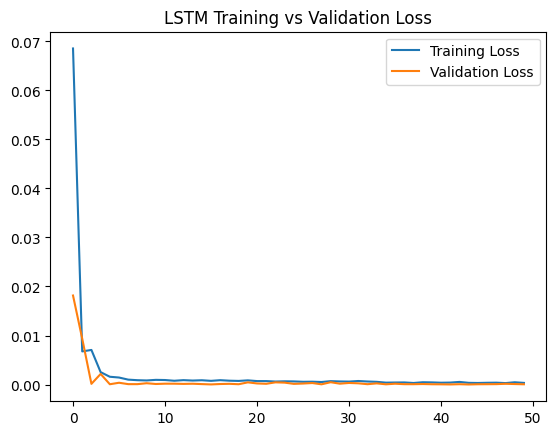

In [23]:
# Plot training vs validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("LSTM Training vs Validation Loss")
plt.show()


In [25]:
# Select a random unseen test sample
random_sample = X_test[5].reshape(1, X_test.shape[1], X_test.shape[2])

# Predict the next calibration date
predicted_days = model.predict(random_sample)

# Convert prediction back to original scale
predicted_original = scaler.inverse_transform([[0, 0, predicted_days[0][0], 0]])[:, 2]

print(f"\n🔹 Predicted Days Until Next Calibration: {predicted_original[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

🔹 Predicted Days Until Next Calibration: 415.01


In [26]:
# Make Predictions
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


In [28]:
# Convert Predictions Back to Original Scale

# Create an array with the correct number of features (4)
num_samples = y_pred.shape[0]  # Get the number of samples in y_pred
transformed_data = np.zeros((num_samples, 4))  # Initialize an array with zeros

# Fill the relevant column with the predictions
transformed_data[:, 3] = y_pred.flatten()  # Assuming 'Days_Until_Next_Calibration' is the 4th column (index 3)

# Apply inverse_transform
y_pred_original = scaler.inverse_transform(transformed_data)[:, 3]  # Extract the predicted 'Days_Until_Next_Calibration'

In [29]:
# Save Predictions
df_predictions = pd.DataFrame({"Actual_Days_Until_Next_Calibration": y_test, "Predicted_Days_Until_Next_Calibration": y_pred_original})
df_predictions.to_csv("LSTM_Predictions.csv", index=False)

In [30]:
# Save Model
model.save("calibration_forecast_lstm.h5")

print("\n LSTM Model Training Complete & Saved!")


 LSTM Model Training Complete & Saved!
